In [1]:
import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
# 수정
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [2]:
data_dir = './dataset-resized'
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

img_size = (128, 128)
batch_size = 32

data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_data = data_gen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = data_gen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_labels = train_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

class_weights = dict(enumerate(class_weights))


Found 3621 images belonging to 5 classes.
Found 904 images belonging to 5 classes.


In [33]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 133s 877ms/step - accuracy: 0.2275 - loss: 1.6346 - val_accuracy: 0.2223 - val_loss: 1.6769
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 95s 831ms/step - accuracy: 0.2877 - loss: 1.5641 - val_accuracy: 0.2080 - val_loss: 1.7179
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 100s 874ms/step - accuracy: 0.3387 - loss: 1.4989 - val_accuracy: 0.1925 - val_loss: 1.7423
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 105s 924ms/step - accuracy: 0.4058 - loss: 1.4354 - val_accuracy: 0.2600 - val_loss: 1.6269
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 106s 928ms/step - accuracy: 0.4326 - loss: 1.3979 - val_accuracy: 0.3009 - val_loss: 1.5421
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 102s 897ms/step - accuracy: 0.4613 - loss: 1.3419 - val_accuracy: 0.3805 - val_loss: 1.4625
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 106s 933ms/step - accuracy: 0.5015 - loss: 1.2865 - val_accuracy: 0.4204 - val_loss: 1.3975
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 105s 921ms/step - accuracy: 0.4950 - 

모델이 './models/waste_classification_model_20250618_081638.h5'에 저장되었습니다.


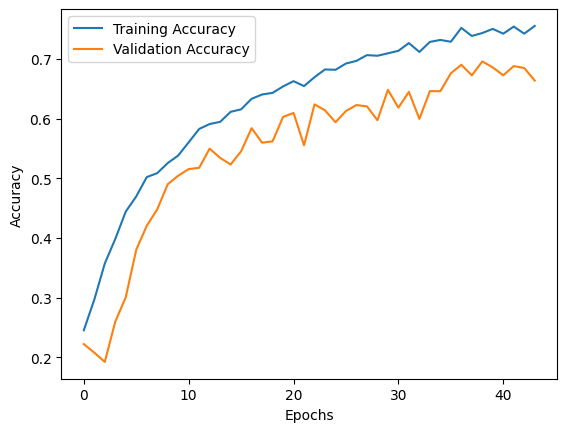

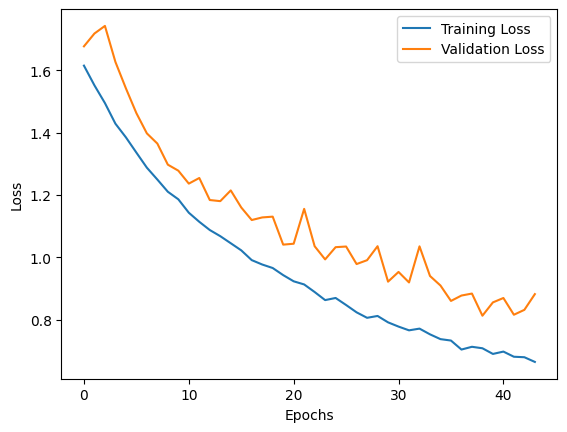

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping],
    class_weight=class_weights
)

import os
import datetime

# models 폴더가 없으면 생성
if not os.path.exists('./models'):
    os.makedirs('./models')

# 현재 시간 문자열 생성
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# 저장 경로에 시간 포함
save_path = f'./models/waste_classification_model_{now}.h5'
model.save(save_path)
print(f"모델이 '{save_path}'에 저장되었습니다.")

# 정확도, 손실 그래프
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions_tf(model, data, class_names, max_images=8):
    images, labels = next(data)  # 배치에서 일부 이미지 추출
    predictions = model.predict(images[:max_images])
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels[:max_images], axis=1)

    plt.figure(figsize=(15, 6))
    for i in range(min(max_images, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f"P:{class_names[pred_classes[i]]}\nT:{class_names[true_classes[i]]}",
                  color='green' if pred_classes[i] == true_classes[i] else 'red')
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


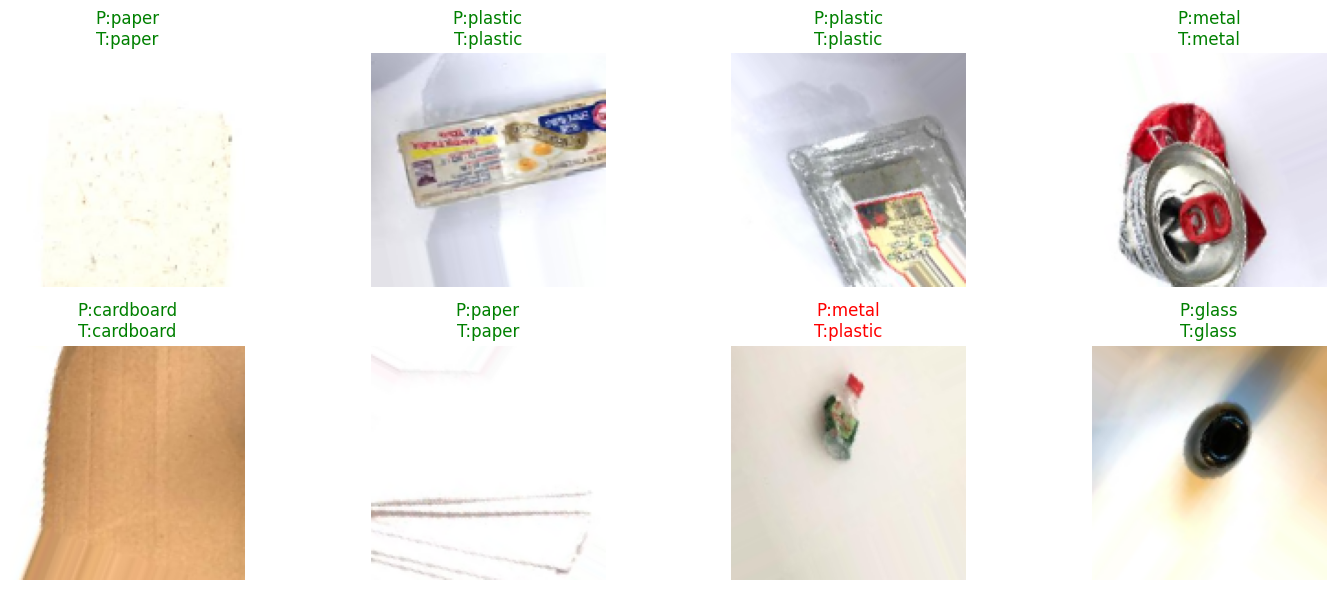

In [39]:
# 학습 후 예측 시각화
show_predictions_tf(model, val_data, categories)

In [55]:
# Step 8: Test the Model (Optional)
def predict_image(image_path):
    from tensorflow.keras.utils import load_img, img_to_array
    import numpy as np

    img = load_img(image_path, target_size=img_size)  # Load image with specified size
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = tf.expand_dims(img_array, 0)  # Expand dimensions to match model input
    
    predictions = model.predict(img_array)  # Get predictions
    class_idx = tf.argmax(predictions[0]).numpy()  # Get class index
    class_label = categories[class_idx]  # Map to class label
    return class_label

# Test with a sample image
sample_image_path = './dataset-resized/cardboard/cardboard_193_cardboard 543.jpg'  # Replace with an actual image path
print("Predicted Class:", predict_image(sample_image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Predicted Class: paper


In [35]:
print("최종 Training Accuracy:", history.history['accuracy'][-1])
print("최종 Validation Accuracy:", history.history['val_accuracy'][-1])

최종 Training Accuracy: 0.7553161978721619
최종 Validation Accuracy: 0.6637167930603027


In [36]:
print("Train Loss:", history.history['loss'][-1])
print("Val Loss:", history.history['val_loss'][-1])

Train Loss: 0.664196252822876
Val Loss: 0.8817601799964905


In [37]:
print("Epochs trained:", len(history.history['accuracy']))

Epochs trained: 44
